In [72]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.optim as optim
import random
import time
from torch import nn
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'Times New Roman'
})


In [73]:
# Constants and parameters
t1, tf, dt = 0, 10, 0.01
n = int((tf - t1) / dt)
t = np.linspace(t1, tf, n)
print(n)

1000


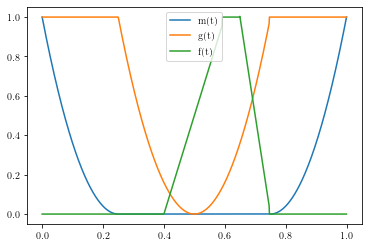

In [74]:
#time dependent control functions

#erasure protocol followed from M.Gavrilov et.al., PRL 117,200601(2016)
#the exact expressions of the control functions are given in the SI of P.Singh et.al., Comm. Phys.7:231(2024)

m, g, f = np.zeros([n,1]), np.zeros([n,1]), np.zeros([n,1])

for i in range(0,int(n/4)):
    m[i] = (1 - (t[i]/(0.25*tf)))**2
    g[i] = 1
    f[i] = 0
    
for i in range(int(n/4),int(n/2.5)):
    m[i] = 0
    g[i] = (2 - (t[i]/(0.25*tf)))**2
    f[i] = 0    
    
for i in range(int(n/2.5),int(n/1.69)):
    m[i] = 0
    g[i] = (2 - (t[i]/(0.25*tf)))**2
    f[i] = ((t[i]/tf) - 0.4)/0.2     
    
for i in range(int(n/1.69),int(n/1.54)):
    m[i] = 0
    g[i] = (2 - (t[i]/(0.25*tf)))**2
    f[i] = 1

for i in range(int(n/1.54),int(n/1.34)):
    m[i] = 0
    g[i] = (2 - (t[i]/(0.25*tf)))**2
    f[i] = 1 - ((t[i]/tf) - 0.65)/0.1

for i in range(int(n/1.34),n):
    m[i] = (3 - (t[i]/(0.25*tf)))**2
    g[i] = 1
    f[i] = 0

    
plt.plot(t/tf,m, label='m(t)')
plt.plot(t/tf,g,label='g(t)')
plt.plot(t/tf,f,label='f(t)')
plt.legend()

In [75]:
#given parameters of the dynamics
kb, T = 1.38e-23 , 300
A = 0.3                   # value of A dictates the state of erasing, +A:right well, -A:left well, A~0: no erasing
Eb = 13*kb*T               # barrier height to prevent spontaneous barrier crossing
D = 0.23e-12               # normal diffusion constant
x0 = 0.77e-6               # one of the minima of the potential
eta = 3                    # eta > 1 => Asymmetric double well
tm = (2*x0)**2/D           # mean diffusing time
gamma = (kb*T)/D

print(tm)

10.311304347826088


In [ ]:
kb*T

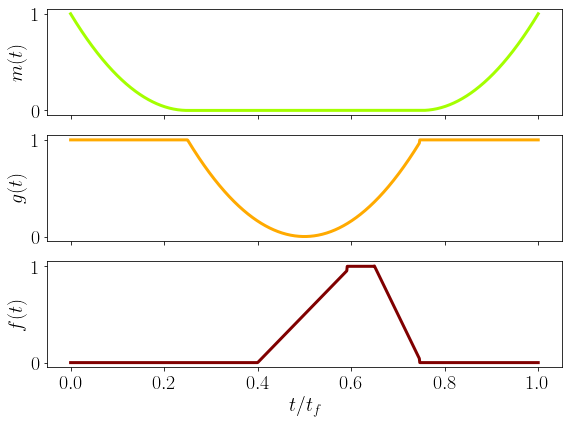

In [76]:

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 6))

axs[0].plot(t/tf, m, color = '#A4FF00', linewidth=3)
axs[0].set_ylabel(r'$m(t)$', fontsize = 20)
axs[0].tick_params(axis='both', labelsize=20)  # Correct tick font size


axs[1].plot(t/tf, g, color = '#FFAA00', linewidth=3)
axs[1].set_ylabel(r'$g(t)$', fontsize = 20)
axs[1].tick_params(axis='both', labelsize=20) 

axs[2].plot(t/tf, f, color = '#800000', linewidth=3)
axs[2].set_ylabel(r'$f(t)$', fontsize = 20)
axs[2].set_xlabel(r'$t/t_f$', fontsize = 20)
axs[2].tick_params(axis='both', labelsize=20) 

plt.tight_layout()
#plt.savefig('protocol_f1_diffsh_.png', format='png',bbox_inches="tight" ,dpi=1200)
plt.show()








Text(0, 0.5, 'x/x0')

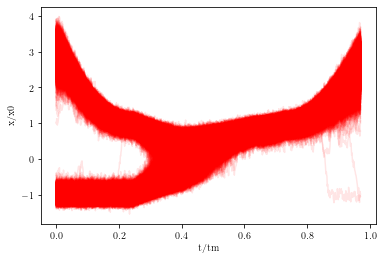

In [77]:
nor = 10000               #no of trajectories

x, xm = np.zeros([n,nor]), np.zeros([n,nor])
diffx,midx = np.zeros([n,nor]), np.zeros([n,nor])
xt = np.zeros([n,nor])

# Vectorized initialization of trajectories
# Half start from -x0, half start from x0 * eta
xt[0, :nor//2] = -x0
xt[0, nor//2:] = x0 * eta

# Vectorized thermalization step
for j in range(n - 1):
    # Compute xn for all trajectories
    xn = np.where(xt[0, :] == -x0, x0, x0 * eta)
    
    # Update xt for all trajectories
    drift = - (dt / gamma) * (4 * Eb) * (-1 * (xt[j, :] / xn**2) + (xt[j, :]**3 / xn**4))
    noise = np.sqrt(2 * D * dt) * np.random.normal(0, 1, nor)
    xt[j + 1, :] = xt[j, :] + drift + noise

# Set initial state for the erasure protocol
x[0, :] = xt[-1, :]

# Vectorized erasure protocol
for i in range(n - 1):
    # Compute xm for all trajectories
    xm[i, :] = np.where(x[i, :] < 0, x0, x0 * (1 + m[i] * (eta - 1)))
    
    # Update x for all trajectories
    drift = - (dt / gamma) * (4 * Eb) * (-g[i] * (x[i, :] / xm[i, :]**2) + (x[i, :]**3 / xm[i, :]**4) - (A * f[i]) / xm[i, :])
    noise = np.sqrt(2 * D * dt) * np.random.normal(0, 1, nor)
    x[i + 1, :] = x[i, :] + drift + noise
        
       

    
plt.plot(t/tm, x/x0,color = 'r',alpha = 0.1)
plt.xlabel('t/tm')
plt.ylabel('x/x0')
            
        

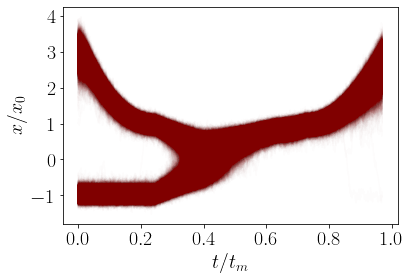

In [ ]:
plt.plot(t/tm, x/x0,color = '#800000',alpha = 0.01)
plt.xlabel(r'$t/t_m$', fontsize = 20)
plt.ylabel(r'$x/x_0$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)


plt.show()


In [79]:
diffx = x[1:,:]- x[:-1,:]
midx = 0.5*(x[1:,:]+ x[:-1,:])

In [80]:
nhalf = int(nor/2)
xl = x[:,:nhalf]
xr = x[:,(nhalf+1):]

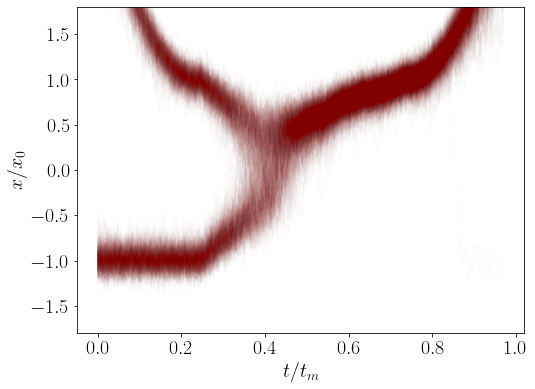

In [ ]:
no_of_traj = np.arange(0,int(nor/50)).flatten()
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(t/tm, xl[:,no_of_traj]/x0,color = '#800000',alpha = 0.01)
plt.plot(t/tm, xr[:,no_of_traj]/x0,color = '#800000',alpha = 0.01)
plt.xlabel(r'$t/t_m$', fontsize = 20)
plt.ylabel(r'$x/x_0$', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim([-1.8, 1.8])


plt.show()

In [ ]:
##ANN algorithm 

import torch
import torch.nn as nn

class DeepRitz_block(nn.Module):
    def __init__(self, h_size):
        super(DeepRitz_block, self).__init__()
        self.dim_h = h_size

        self.activation_function = nn.Tanh()
        block = [nn.Linear(self.dim_h, self.dim_h),
                 self.activation_function,
                 nn.Linear(self.dim_h, self.dim_h),
                 self.activation_function]
        self._block = nn.Sequential(*block)
    def forward(self, x):
        return self._block(x) + x
    

class Neural_Network(nn.Module):
    def __init__(self, in_size, h_size = 10, block_size = 1, dev="cpu"):
        super(Neural_Network, self).__init__()
        self.num_blocks = block_size
        self.dim_x = in_size
        self.dim_h = h_size
        self.dev = dev
        self.dim_input = self.dim_x
        
        # assemble the neural network with DeepRitz blocks
        self._block = DeepRitz_block(self.dim_h)
        if self.dim_h > self.dim_input:
            model = [nn.ConstantPad1d((0, self.dim_h - self.dim_input), 0)]
        else:
            model = [nn.Linear(self.dim_input, self.dim_h)]
        for _ in range(self.num_blocks):
            model.append(self._block)
        #model.append(nn.Linear(self.dim_h, self.dim_x)) #MODIFIED
        model.append(nn.Linear(self.dim_h, self.dim_x - 1)) 
        self._model = nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

In [100]:
x_dim = 1
epochs = 1000
batch_size = 32 # Use mini-batches
lr = 1e-3
epsilon = 1e-8  # For numerical stability

dim_x, dim_h, num_blocks = x_dim+1, 10, 2

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
neural_network = Neural_Network(dim_x, dim_h, num_blocks, device).to(device)


cpu


In [101]:

# Initialize network and optimizer
force_network = neural_network
optimizer = optim.Adadelta(force_network.parameters(), lr=lr)

# Training loop
sig = []  # For tracking loss

xn=xl.T
y= torch.tensor(xn, dtype=torch.float32).unsqueeze(2) ## unsqueeze only required for 1D data
# for many d, skip the above line

midyn = (y[:,1:,:]+y[:,:-1,:])/2
diffyn = y[:,1:,:]-y[:,:-1,:]

L = midyn.shape[1]
(num_traj,length) = xn.shape


for episode in range(1):
    indices = random.sample(range(L), batch_size)
    ep_loss = []
    for epoch in trange(epochs, desc="Training"):
        time_axis = torch.arange(L, device=device) * dt  # Time axis
        # Sample a batch of indices
        data_mid = midyn[:,indices, :].T.to(device).permute(2, 1, 0)  # Shape: [time_steps, batch_size]
        xdiff = diffyn[:,indices, :].T.unsqueeze(2).to(device).permute(3, 1, 0, 2)  # Shape: [time_steps, batch_size, 1]
        time_inputs = time_axis[indices][None, :, None].expand(num_traj, -1,1)  # Shape: [time_steps, batch_size]
        xx_in = torch.cat([data_mid, time_inputs], dim=2)
       
        dxmid = force_network(xx_in.view(-1, x_dim + 1))  # Flatten for the network
        dxmid = dxmid.view(xx_in.shape[0], -1, x_dim)#.permute(1, 0, 2)  # Reshape to [time_steps, batch_size, x_dim]
        
        assert dxmid.shape[0] == xdiff.shape[0], f"Shape mismatch: dxmid={dxmid.shape}, xdiff={xdiff.shape}"

        # Compute loss
        jj = torch.sum(dxmid[:,:,:] * xdiff.squeeze(-1), dim=2)  # Element-wise multiplication and sum along x_dim

        mean_jj = torch.mean(jj, dim=0)
        var_jj = torch.var(jj, dim=0)

        loss = torch.sum( -2 * mean_jj**2 / (dt * (var_jj)))  # Add epsilon for stability
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ep_loss.append(loss.item())


Training: 100%|██████████| 1000/1000 [00:56<00:00, 17.70it/s]


In [102]:
y.shape

torch.Size([5000, 1000, 1])

Training: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

torch.Size([999])


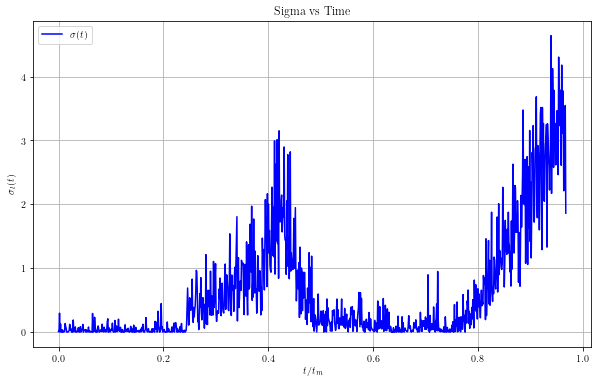

In [103]:
import matplotlib.pyplot as plt

# Set up parameters for the computation
#L = 499  # Number of time steps

# Prepare time points
time_points = torch.arange(L, device=device).float() * dt  # t = i * dt

# Initialize a list to store sigma(t)
sigma_tl = []
const_fact =[]
#Initialize an array to store local dissipation as optimal current
optim_jjl = torch.zeros(L, midyn.shape[1], device=device) 

# Compute sigma(t) for each time step
for episode in range(1):
    indices = np.arange(0,L,1)
    ep_loss = []
    for epoch in trange(1, desc="Training"):
        time_axis = torch.arange(L, device=device) * dt  # Time axis
        # Sample a batch of indices
        data_mid = midyn[:,indices, :].T.to(device).permute(2, 1, 0)  # Shape: [time_steps, batch_size]
        xdiff = diffyn[:,indices, :].T.unsqueeze(2).to(device).permute(3, 1, 0, 2)  # Shape: [time_steps, batch_size, 1]
        time_inputs = time_axis[indices][None, :, None].expand(num_traj, -1,1)  # Shape: [time_steps, batch_size]
        #xx_in = torch.stack([data_mid, time_inputs], dim=2)  # Shape: [time_steps, batch_size, x_dim + 1]
        xx_in = torch.cat([data_mid, time_inputs], dim=2)
        #print(data_mid.shape, time_inputs.shape,xx_in.shape)
        # Forward pass
        #print(xx_in.view(-1, x_dim + 1).shape)
       
        dxmid = force_network(xx_in.view(-1, x_dim + 1))  # Flatten for the network
        #dxmid = dxmid.view(len(indices), -1, x_dim).permute(1, 0, 2)  # Reshape to [time_steps, batch_size, x_dim]
        dxmid = dxmid.view(xx_in.shape[0], -1, x_dim)#.permute(1, 0, 2)  # Reshape to [time_steps, batch_size, x_dim]
        
        #dxmid = dxmid.view(len(indices), -1, x_dim).permute(1, 0, 2)  # Reshape to [time_steps, batch_size, x_dim]
        assert dxmid.shape[0] == xdiff.shape[0], f"Shape mismatch: dxmid={dxmid.shape}, xdiff={xdiff.shape}"

        # Reshape xdiff to match dxmid
        #xdiff = xdiff.permute(1, 0, 2)  # Shape: [batch_size, time_steps, x_dim]
        # Compute loss
        jj = torch.sum(dxmid[:,:,:] * xdiff.squeeze(-1), dim=2)  # Element-wise multiplication and sum along x_dim

        mean_jj = torch.mean(jj, dim=0)
        var_jj = torch.var(jj, dim=0)

        #loss = -2 * mean_jj**2 / (dt * (var_jj + epsilon))  # Add epsilon for stability
        #epr = 2 * mean_jj**2 / (dt * (var_jj)) # Add epsilon for stability

        sigma = 2 * mean_jj**2 / (dt * var_jj)
        print(sigma.shape)
        sigma_tl.append(sigma.tolist())  # Store sigma(t)
    
        const_fact_ = 2*mean_jj/var_jj
        optim_jjl = (  jj * const_fact_[ None, :])
        const_fact.append(const_fact_.tolist())
        
# Convert sigma_t to a tensor for plotting
sigma_tl = torch.tensor(sigma_tl)
# Plot sigma(t) vs. time
plt.figure(figsize=(10, 6))
plt.plot(time_points.cpu()/tm, sigma_tl.cpu().squeeze(), label=r'$\sigma(t)$', color='blue')

#plt.plot(time_points.cpu(), 1-np.exp(-time_points.cpu()), label=r'$1 - \exp(-t)$', color='red')
plt.xlabel(r'$t/t_m$')
plt.ylabel(r'$\sigma_l(t)$')
plt.title('Sigma vs Time')
plt.legend()
plt.grid()
plt.show()






In [104]:
jj.shape

torch.Size([5000, 999])

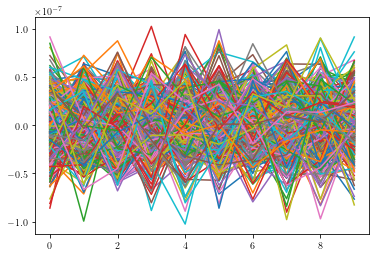

In [105]:
plt.plot(jj.detach().numpy()[:10,:])

In [106]:
#PLOTTING

for episode in range(1):
    indices = np.arange(0,L,1)
    ep_loss = []
    for epoch in trange(1, desc="Training"):
        time_axis = torch.arange(L, device=device) * dt  # Time axis
        # Sample a batch of indices
        data_mid = midyn[:,indices, :].T.to(device).permute(2, 1, 0)  # Shape: [time_steps, batch_size]
        xdiff = diffyn[:,indices, :].T.unsqueeze(2).to(device).permute(3, 1, 0, 2)  # Shape: [time_steps, batch_size, 1]
        time_inputs = time_axis[indices][None, :, None].expand(num_traj, -1,1)  # Shape: [time_steps, batch_size]
        #xx_in = torch.stack([data_mid, time_inputs], dim=2)  # Shape: [time_steps, batch_size, x_dim + 1]
        xx_in = torch.cat([data_mid, time_inputs], dim=2)
        #print(data_mid.shape, time_inputs.shape,xx_in.shape)
        # Forward pass
        #print(xx_in.view(-1, x_dim + 1).shape)
       
        dxmid = force_network(xx_in.view(-1, x_dim + 1))  # Flatten for the network
        #dxmid = dxmid.view(len(indices), -1, x_dim).permute(1, 0, 2)  # Reshape to [time_steps, batch_size, x_dim]
        dxmid = dxmid.view(xx_in.shape[0], -1, x_dim)#.permute(1, 0, 2)  # Reshape to [time_steps, batch_size, x_dim]
        
        #dxmid = dxmid.view(len(indices), -1, x_dim).permute(1, 0, 2)  # Reshape to [time_steps, batch_size, x_dim]
        assert dxmid.shape[0] == xdiff.shape[0], f"Shape mismatch: dxmid={dxmid.shape}, xdiff={xdiff.shape}"

        # Reshape xdiff to match dxmid
        #xdiff = xdiff.permute(1, 0, 2)  # Shape: [batch_size, time_steps, x_dim]
        # Compute loss
        jj = torch.sum(dxmid[:,:,:] * xdiff.squeeze(-1), dim=2)  # Element-wise multiplication and sum along x_dim

        mean_jj = torch.mean(jj, dim=0)
        var_jj = torch.var(jj, dim=0)

        #loss = -2 * mean_jj**2 / (dt * (var_jj + epsilon))  # Add epsilon for stability
        epr = 2 * mean_jj**2 / (dt * (var_jj)) # Add epsilon for stability



Training: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


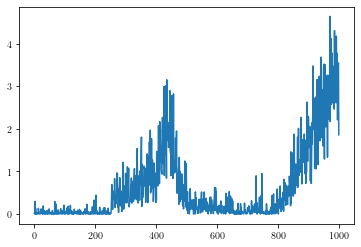

In [107]:
plt.plot(epr.detach().numpy())

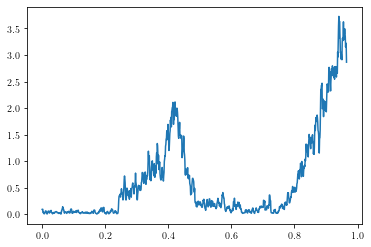

In [108]:
sig_annl = epr.detach().numpy()
smoothed_data_l = moving_average(sig_annl, window_size=5)

#smoothed_data_r = sig_polyr.flatten()
# Create segments for color mapping
t_smoothed = t[:len(smoothed_data_l)]  # Ensure t matches smoothed data length

plt.plot(t_smoothed/tm, smoothed_data_l  )

#plt.savefig('ep_right_to_right_poly_f1.png', format='png',bbox_inches="tight" ,dpi=1200)
plt.show()


In [109]:

# Initialize network and optimizer
force_network = neural_network
optimizer = optim.Adadelta(force_network.parameters(), lr=lr)

# Training loop
sig = []  # For tracking loss

xn=xr.T
y= torch.tensor(xn, dtype=torch.float32).unsqueeze(2) ## unsqueeze only required for 1D data
# for many d, skip the above line

midyn = (y[:,1:,:]+y[:,:-1,:])/2
diffyn = y[:,1:,:]-y[:,:-1,:]

L = midyn.shape[1]
(num_traj,length) = xn.shape


for episode in range(1):
    indices = random.sample(range(L), batch_size)
    ep_loss = []
    for epoch in trange(epochs, desc="Training"):
        time_axis = torch.arange(L, device=device) * dt  # Time axis
        # Sample a batch of indices
        data_mid = midyn[:,indices, :].T.to(device).permute(2, 1, 0)  # Shape: [time_steps, batch_size]
        xdiff = diffyn[:,indices, :].T.unsqueeze(2).to(device).permute(3, 1, 0, 2)  # Shape: [time_steps, batch_size, 1]
        time_inputs = time_axis[indices][None, :, None].expand(num_traj, -1,1)  # Shape: [time_steps, batch_size]
        xx_in = torch.cat([data_mid, time_inputs], dim=2)
       
        dxmid = force_network(xx_in.view(-1, x_dim + 1))  # Flatten for the network
        dxmid = dxmid.view(xx_in.shape[0], -1, x_dim)#.permute(1, 0, 2)  # Reshape to [time_steps, batch_size, x_dim]
        
        assert dxmid.shape[0] == xdiff.shape[0], f"Shape mismatch: dxmid={dxmid.shape}, xdiff={xdiff.shape}"

        # Compute loss
        jj = torch.sum(dxmid[:,:,:] * xdiff.squeeze(-1), dim=2)  # Element-wise multiplication and sum along x_dim

        mean_jj = torch.mean(jj, dim=0)
        var_jj = torch.var(jj, dim=0)

        loss = torch.sum( -2 * mean_jj**2 / (dt * (var_jj)))  # Add epsilon for stability
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ep_loss.append(loss.item())


Training: 100%|██████████| 1000/1000 [00:50<00:00, 19.82it/s]


Training: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

torch.Size([999])


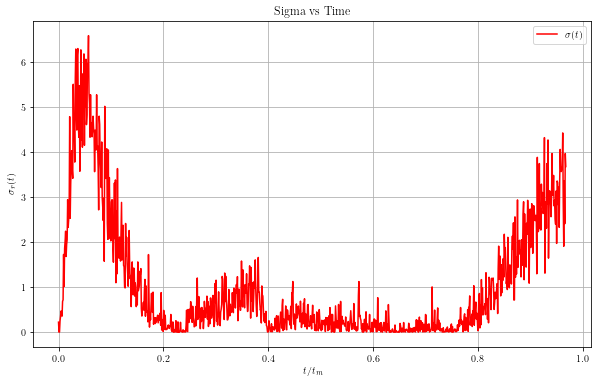

In [110]:
import matplotlib.pyplot as plt

# Set up parameters for the computation
#L = 499  # Number of time steps

# Prepare time points
time_points = torch.arange(L, device=device).float() * dt  # t = i * dt

# Initialize a list to store sigma(t)
sigma_tr = []
const_fact_r =[]
#Initialize an array to store local dissipation as optimal current
optim_jjr = torch.zeros(L, midyn.shape[1], device=device) 


# Compute sigma(t) for each time step
for episode in range(1):
    indices = np.arange(0,L,1)
    ep_loss = []
    for epoch in trange(1, desc="Training"):
        time_axis = torch.arange(L, device=device) * dt  # Time axis
        # Sample a batch of indices
        data_mid = midyn[:,indices, :].T.to(device).permute(2, 1, 0)  # Shape: [time_steps, batch_size]
        xdiff = diffyn[:,indices, :].T.unsqueeze(2).to(device).permute(3, 1, 0, 2)  # Shape: [time_steps, batch_size, 1]
        time_inputs = time_axis[indices][None, :, None].expand(num_traj, -1,1)  # Shape: [time_steps, batch_size]
        #xx_in = torch.stack([data_mid, time_inputs], dim=2)  # Shape: [time_steps, batch_size, x_dim + 1]
        xx_in = torch.cat([data_mid, time_inputs], dim=2)
        #print(data_mid.shape, time_inputs.shape,xx_in.shape)
        # Forward pass
        #print(xx_in.view(-1, x_dim + 1).shape)
       
        dxmid = force_network(xx_in.view(-1, x_dim + 1))  # Flatten for the network
        #dxmid = dxmid.view(len(indices), -1, x_dim).permute(1, 0, 2)  # Reshape to [time_steps, batch_size, x_dim]
        dxmid = dxmid.view(xx_in.shape[0], -1, x_dim)#.permute(1, 0, 2)  # Reshape to [time_steps, batch_size, x_dim]
        
        #dxmid = dxmid.view(len(indices), -1, x_dim).permute(1, 0, 2)  # Reshape to [time_steps, batch_size, x_dim]
        assert dxmid.shape[0] == xdiff.shape[0], f"Shape mismatch: dxmid={dxmid.shape}, xdiff={xdiff.shape}"

        # Reshape xdiff to match dxmid
        #xdiff = xdiff.permute(1, 0, 2)  # Shape: [batch_size, time_steps, x_dim]
        # Compute loss
        jj = torch.sum(dxmid[:,:,:] * xdiff.squeeze(-1), dim=2)  # Element-wise multiplication and sum along x_dim

        mean_jj = torch.mean(jj, dim=0)
        var_jj = torch.var(jj, dim=0)

        #loss = -2 * mean_jj**2 / (dt * (var_jj + epsilon))  # Add epsilon for stability
        #epr = 2 * mean_jj**2 / (dt * (var_jj)) # Add epsilon for stability

        sigma = 2 * mean_jj**2 / (dt * var_jj)
        print(sigma.shape)
        sigma_tr.append(sigma.tolist())  # Store sigma(t)
    
        const_fact_ = 2*mean_jj/var_jj
        const_fact_r.append(const_fact_.tolist())
        # Loop over time steps, example inside a loop
        optim_jjr = (  jj * const_fact_[ None, :])

# Convert sigma_t to a tensor for plotting
sigma_tr = torch.tensor(sigma_tr)
#optim_jjr = const_fact_r[:, None] * jj
# Plot sigma(t) vs. time
plt.figure(figsize=(10, 6))
plt.plot(time_points.cpu()/tm, sigma_tr.cpu().squeeze(), label=r'$\sigma(t)$', color='red')

#plt.plot(time_points.cpu(), 1-np.exp(-time_points.cpu()), label=r'$1 - \exp(-t)$', color='red')
plt.xlabel(r'$t/t_m$')
plt.ylabel(r'$\sigma_r(t)$')
plt.title('Sigma vs Time')
plt.legend()
plt.grid()
plt.show()






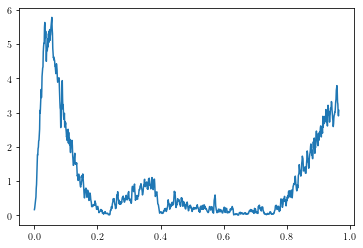

In [111]:
sig_annr = sigma_tr.detach().numpy()
smoothed_data_r = moving_average(sig_annr, window_size=5)

#smoothed_data_r = sig_polyr.flatten()
# Create segments for color mapping
t_smoothed = t[:len(smoothed_data_r)]  # Ensure t matches smoothed data length

plt.plot(t_smoothed/tm, smoothed_data_r  )

#plt.savefig('ep_right_to_right_poly_f1.png', format='png',bbox_inches="tight" ,dpi=1200)
plt.show()


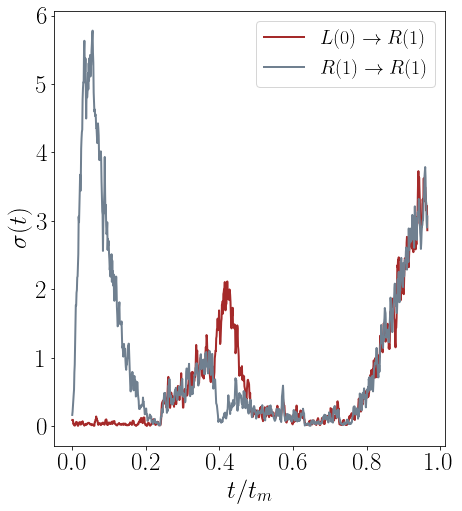

In [ ]:
fig, ax = plt.subplots(figsize=(7, 8))
plt.plot(t_smoothed/tm, smoothed_data_l, linewidth=2, color = '#A52A2A' ,label=r'$L(0) \rightarrow R(1)$' )
plt.plot(t_smoothed/tm, smoothed_data_r, linewidth=2, color = '#708090', label=r'$R(1) \rightarrow R(1)$' )

plt.xlabel(r'$t/t_m$',fontsize=25)
plt.ylabel(r'$\sigma(t)$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)

plt.show()

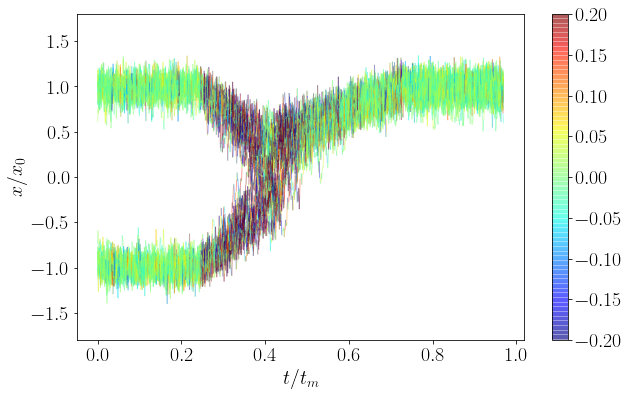

In [ ]:
# trajectroy plot with the time dependent local dissipation


from matplotlib.collections import LineCollection

req = L
sig1 = optim_jjr.detach().numpy()
sig2 = optim_jjl.detach().numpy() 
fig9, ax = plt.subplots(figsize=(10, 6))

# no_of_traj = np.concatenate((np.arange(0,int(nor/5)), (np.arange(int(nor/1.2),nor)))).flatten()
no_of_traj = np.arange(0,int(nor/500)).flatten()
for j in (no_of_traj):
    points = np.array([t[0:req].flatten()/tm, xr[0:req,j].flatten()/x0]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    
    #lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(sig1.min(), sig1.max()))
    lc = LineCollection(segments, cmap='jet' , alpha = 0.4, norm=plt.Normalize(-0.2,0.2))
    lc.set_array(sig1[j,:])
    lc.set_linewidth(1)
    ax.add_collection(lc)
    
    points2 = np.array([t[0:req].flatten()/tm, xl[0:req,j].flatten()/x0]).T.reshape(-1, 1, 2)
    segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)

    
    #lc2 = LineCollection(segments2, cmap='viridis', norm=plt.Normalize(sig2.min(), sig2.max()))
    lc2 = LineCollection(segments2, cmap='jet' , alpha = 0.4, norm=plt.Normalize(-0.2,0.2))
    lc2.set_array(sig2[j,:])
    lc2.set_linewidth(1)
    ax.add_collection(lc2)

    # Plot
    
    
ax.autoscale()  # Automatically adjusts the axis to fit the line
#ax.set_xlim(t.min(), t.max())
#ax.set_ylim(x.min(), x.max())
cbar = plt.colorbar(lc, ax=ax)
#cbar.set_label(r'$\sigma^{loc}_{th}(t)$',fontsize=20)
#cbar.set_label(r'$\sigma(t)$',fontsize=20)
cbar.ax.tick_params(labelsize=20) 
plt.xlabel(r'$t/t_m$',fontsize=20)
plt.ylabel(r'$x/x_0$',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-1.8, 1.8])

plt.show()